<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, old_plot_latency_angle_hist
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

In [2]:
#sd = spike_data.read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-11-13-e-Hc110723_hckcr1_21841/elliott/hc110723_2.zip")
with open("hc110723_curated.pkl", "rb") as f:
    sd = pickle.load(f)

In [4]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

#https://medium.com/@dreamferus/how-to-synchronize-time-series-using-cross-correlation-in-python-4c1fd5668c7a#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImM3ZTExNDEwNTlhMTliMjE4MjA5YmM1YWY3YTgxYTcyMGUzOWI1MDAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5NDUwNDY4Mjk4NDg1MzY1NjYiLCJoZCI6InVjc2MuZWR1IiwiZW1haWwiOiJtZWxsaW90MUB1Y3NjLmVkdSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE2OTM1MTg3MjksIm5hbWUiOiJNYXR0IEVsbGlvdHQiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUFjSFR0ZWRoeVRrWk1hU1hJRTFqa1hhZEVmbmhxc3NwNW1lVFkzUHV0THluMVJ1TXc9czk2LWMiLCJnaXZlbl9uYW1lIjoiTWF0dCIsImZhbWlseV9uYW1lIjoiRWxsaW90dCIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNjkzNTE5MDI5LCJleHAiOjE2OTM1MjI2MjksImp0aSI6Ijc5NGMxOTk1NmI5NDJiNWQzNGIzODc0YTdjYzQ1ZTgyZTlkNjdjZTYifQ.mrDH7b9_D0YfYF3xxqJl-Kh5w_XeWgpyntt19-Bvs4VJJpuJR5DRRJsSGO52guE8jSdYsSDS_ILzPyY_rZAyivCZ4mXJv3CftxbNxgxRD_feS8BNI3YPbTh2Oin7tj32Gzm75Nq4k-UnhQxy9d7qVlw29DA6Wns1yTY0B6cb0pPEuKMWfHmlmCUEtDEDX0dE__pUGkBxWwickpa2n-pW-Z71y-hatFAn80JrOPclPZj1Yts9xeV9uPC7ICWTjSVLZB4Nl8mKy6Rxn6pB_ny01ne06iAoYidx2SwRU3j5BVZF1CK-bhVqQ-qOuzIPj17qvkFE9RJT9Zw842YN9f16MA
def cross_correlation_max_shift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=15, sttc_cutoff = 0.04, latency_cutoff=1, sigma=15, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
        if abs(np.median(pair_latencies))> latency_cutoff:
            pairs_late.append( pair )  #lags_late.append( latency )
    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        x = np.around( sd.train[pair[0]] ).astype(int)
        y= np.around( sd.train[pair[1]] ).astype(int)
        x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        x_long[ x ] = 1
        y_long[ y ] = 1
        x_smooth = gaussian_filter(x_long, sigma=sigma) # sigma=15
        y_smooth = gaussian_filter(y_long, sigma=sigma) # sigma=15
        
        cross_lag.append( cross_correlation_max_shift( x_smooth, y_smooth ) ) 

    cross_lag = np.array(cross_lag)
    to_keep = np.where((np.abs(cross_lag)< cross_sttc_max_cutoff) & (np.abs(cross_lag)> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 


In [5]:
good_pairs = curate_latencies(sd)
with open( 'hc110723_good_pairs.pkl' , 'wb') as my_file:
   pickle.dump(good_pairs, my_file)
##load pickled data
# with open( 'cutsd_curate_latencies_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# print(len(good_pairs))

11881 Starting Pairs


/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/analysis/analysis.py:1059: RuntimeWarning: invalid value encountered in scalar divide
  PB = _sttc_na(tB, tA, delt) / len(tB)
/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/analysis/analysis.py:1058: RuntimeWarning: invalid value encountered in scalar divide
  PA = _sttc_na(tA, tB, delt) / len(tA)


2123 pairs above sttc cutoff
1035 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
10 pairs between cross_sttc cutoffs


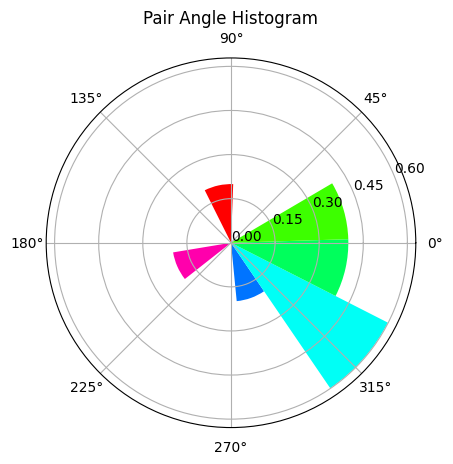

In [6]:
plot_latency_angle_hist( sd, good_pairs)

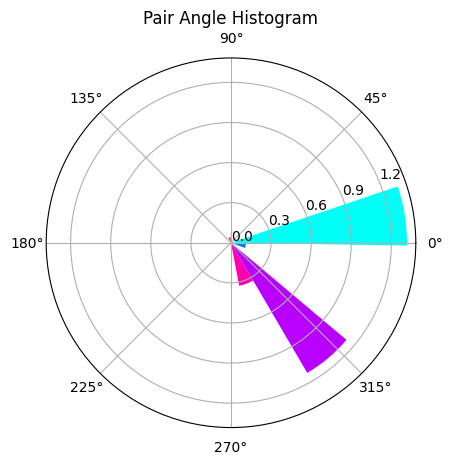

In [7]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True)

# Vector Plots

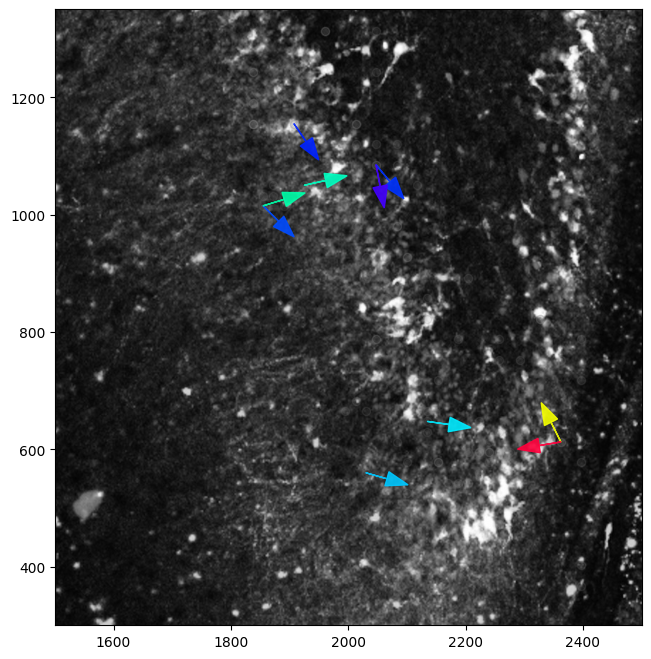

In [8]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc110723_bw.jpeg",
                   xlim=(1500,2500), ylim=(300,1350) )

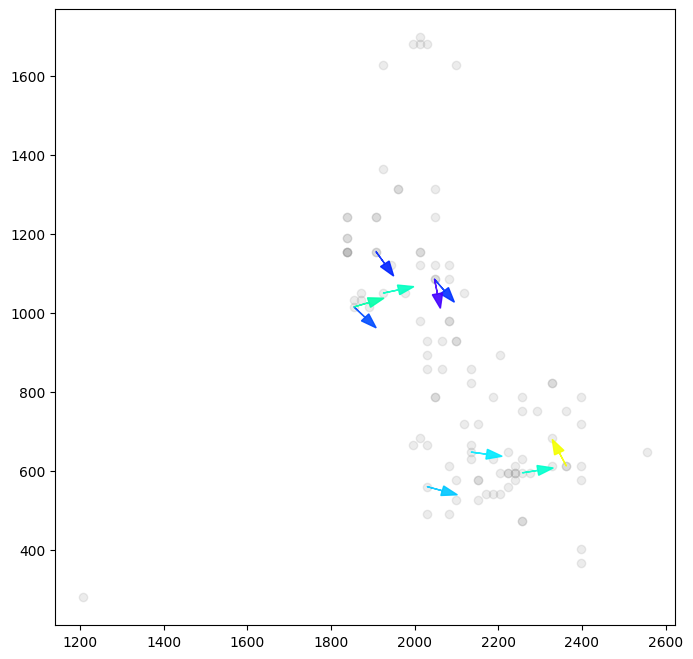

In [9]:
plot_vector_layout( sd, good_pairs)

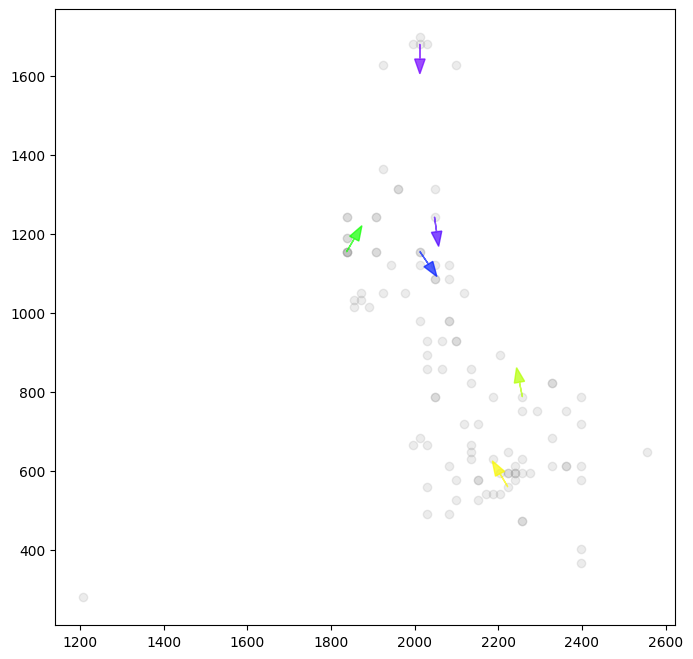

In [12]:
plot_vector_layout( sd, good_pairs, min_dist=500 )